In [2]:
import numpy as np
import sys, os 
sys.path.append('../Netket/')
sys.path.append('../ClusterExpansion/')
import netket as nk
import itertools
import matplotlib.pyplot as plt 
import cluster_expansion as ce
# from cluster_expansion import fwht_coeffs_in_cluster_col_order, prepare_fwht_meta_cached, compress_and_reconstruct_cached, _get_topk_indices_jit
import analysis
from analysis import std_phase, ipr, pca_entropy, renyi_entropy, mean_amplitude, uniform_state_overlap, infidelity
import pandas as pd
from functools import partial
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_regression
from xgboost import XGBRegressor


ERROR:2026-01-27 18:01:30,891:jax._src.xla_bridge:475: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/scratch/ashankar/DataMiningRBMs/.venv/lib/python3.13/site-packages/jax/_src/xla_bridge.py", line 473, in discover_pjrt_plugins
    plugin_module.initialize()
    ~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/scratch/ashankar/DataMiningRBMs/.venv/lib/python3.13/site-packages/jax_plugins/xla_cuda12/__init__.py", line 328, in initialize
    _check_cuda_versions(raise_on_first_error=True)
    ~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/scratch/ashankar/DataMiningRBMs/.venv/lib/python3.13/site-packages/jax_plugins/xla_cuda12/__init__.py", line 285, in _check_cuda_versions
    local_device_count = cuda_versions.cuda_device_count()
RuntimeError: jaxlib/cuda/versions_helpers.cc:113: operation cuInit(0) failed: Unknown CUDA error 303; cuGetErrorName failed. This probably means that JAX was unable to load 

∣NK⟩ Tip: Prefer the new nk.driver.VMC_SR over VMC which supports minSR and SPRING.

In [8]:
import importlib
importlib.reload(analysis)

<module 'analysis' from '/scratch/ashankar/DataMiningRBMs/datamine/../Netket/analysis.py'>

In [7]:
data_root = '..'
data_dirs_set = ['data_optimal_basis_rbm', 'extended_data_optimal_basis_rbm']
datadirs = [f'{data_root}/data/{data_dir_val}' for data_dir_val in data_dirs_set]
h5_files_opt = [f'{data_root}/data/{data_dir_val}/{fp}' for data_dir_val in datadirs for fp in os.listdir(data_dir_val) if fp.endswith('.h5')]

df_opt = analysis.load_outputs_to_dataframe_mult_thread(h5_files_opt, load_eigenstates=False, num_workers=4)
df_opt["idx"] = df_opt["file"].apply(lambda x: int(os.path.basename(x).split('_')[2]))
print(len(df_opt))

AssertionError: 

In [ ]:
# hypotheses = {
#     "std_phase" : std_phase,
#     "IPR" : ipr,
#     "SPCA" : pca_entropy,
#     "Renyi_2" : renyi_entropy,
#     "uniform_state_overlap" : uniform_state_overlap,
#     "mean_amplitude" : mean_amplitude,
# }

def sort_normalize(v):
    vs = np.sort(np.abs(v))[::-1]
    # return vs / np.linalg.norm(vs)
    return vs #/ vs[0]

def relative_weights(v, max_N):
    vs = np.sort(np.abs(v))[::-1]
    return np.sum(vs[1:max_N]) /  vs[0]
    # return np.sum(vs[max_N+1:-1]) /  np.sum(vs[0:max_N])

def cluster_expansion_decay(logpsi,hilbert, max_N):
    """
    estimates the decay of cluster expansion coefficients by expanding logpsi = W + \\sum_i c_i \\sigma_i + \\sum_{i<j} c_{ij} \\sigma_i \\sigma_j + .... for the max_N most significant terms
    """
    cluster_coeffs_test_exact = ce.fwht_coeffs_in_cluster_col_order(logpsi, hilbert)
    sorted_c = sort_normalize(cluster_coeffs_test_exact)
    # relweights = relative_weights(sorted_c, max_N)
    gradient, _ = np.polyfit(np.arange(len(sorted_c))[:max_N], np.log(np.abs(sorted_c) + 1e-16)[:max_N], 1)
    decay_const = -gradient

    return decay_const

# Define the CEdecay lambda function
# CEdecay = lambda x: cluster_expansion_decay(np.log(x), nk.hilbert.Spin(1/2, N=16), max_N=16**2+32)
def CEdecay(psi, max_N=16**2+32):
    hilbert = nk.hilbert.Spin(1/2, N=16)
    ce1 = cluster_expansion_decay(np.log(psi), hilbert, max_N=max_N)
    return ce1
    # ce2 = cluster_expansion_decay(psi, hilbert, max_N=16**2+32)
    # return np.min([ce1, ce2])

def CEEntropy(psi):
    hilbert = nk.hilbert.Spin(1/2, N=16)

    cluster_coeffs_test_exact = ce.fwht_coeffs_in_cluster_col_order(np.log(psi), hilbert)
    sorted_c = sort_normalize(cluster_coeffs_test_exact)
    sorted_c = sorted_c / np.sum(sorted_c)
    num_c = len(sorted_c)
    return -1/np.log(num_c) * np.sum(sorted_c * np.log(sorted_c))


def phase_nonrandomness(psi):
    sigma = std_phase(psi)
    return np.abs(sigma - np.pi/np.sqrt(3))

hypotheses_CC = {
    "phase_nonrandomness": phase_nonrandomness,
    "IPR": ipr,
    "SPCA": pca_entropy,
    "uniform_state_overlap": uniform_state_overlap,
    "CEEntropy" : CEEntropy,
    # "uniform_state_overlap2": uniform_state_overlap,

    # "CE": CEdecay,
    # "CE20": partial(CEdecay, max_N=20),
}



# Reload analysis module to ensure fresh state before applying hypotheses
importlib.reload(analysis)

df_mine = analysis.attach_hypotheses_fields_mult_thread(df_opt, hypotheses_CC, num_workers=4)

In [ ]:
# # features = list(hypotheses_CC.keys())
# features = ['CEEntropy', 'SPCA']
# # features = ['uniform_state_overlap']
# # features = ['uniform_state_overlap', 'std_phase']
# traindf = df_mine[features + ['Delta_E']].dropna()
# traindf = traindf[traindf['Delta_E'] <  0.1] # 0.1 = 10% relative error 
# # traindf = traindf[traindf['uniform_state_overlap'] > 0.05]
# # traindf = df_mine[features + ['infidelity']].dropna()
# # trindf = traindf[traindf['infidelity'] < 0.9]
# print(len(traindf))
# X_train, X_test, y_train, y_test = train_test_split(traindf[features], traindf['Delta_E'], test_size=0.2, random_state=42)
# print(len(X_train), len(X_test))
# model = RandomForestRegressor(n_estimators=1000, random_state=42)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# y_pred_train = model.predict(X_train)
# mse = mean_squared_error(y_test, y_pred)
# print('Mean Squared Error on training set prediction : ', mean_squared_error(y_train, y_pred_train))
# print('Perecentage error in training set prediction :', 100 * np.mean(np.abs(y_train - y_pred_train) / y_train))
# print(f"Mean Squared Error: {mse}") 
# print("Percentage error in prediction:", 100 * np.mean(np.abs(y_test - y_pred) / y_test))

In [ ]:
# fig, ax = plt.subplots()
# print(len(y_test))
# ax.scatter(y_test, y_pred, alpha=0.8,label='Test set')
# ax.scatter(y_train, y_pred_train, alpha=0.3, color='orange',label='Train set')
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlabel('True Delta E')   
# ax.set_ylabel('Predicted Delta E')
# ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='y=x line')
# ax.legend()
# ax.text(0.001, min(y_pred)*2, f'Mean Squared Error: {mse:.2e}', fontsize=10)
# # ax.scatter(y_test, y_pred_xgb, alpha=0.5, color='green')

In [ ]:
# fig, ax = plt.subplots(1)
# target_feature = 'Delta_E'

# feature_subset = features.copy()
# try:
#     feature_subset.remove(target_feature)
# except ValueError:
#     pass    

# mutual_information = mutual_info_regression(traindf[feature_subset], traindf[target_feature])
# ax.bar(feature_subset, mutual_information, color='orange', alpha=1.0)
# ax.set_xticklabels(features, rotation=45, ha='right')
# ax.set_ylabel('Mutual Information with Delta E')

In [ ]:
# import seaborn as sns
# corr = traindf.corr()
# sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
   

In [ ]:
features = list(hypotheses_CC.keys()) + ['E_gap']
print(features)
feature_combinations = []
for r in range(1, len(features)+1):
    feature_combinations.extend(itertools.combinations(features, r))
print(f"Total combinations to evaluate: {len(feature_combinations)}")

mselist = np.ones(len(feature_combinations)) * np.inf
best_model = None


for f_idx, feature_set in enumerate(feature_combinations):
    feature_set = list(feature_set)
    traindf = df_mine[feature_set + ['Delta_E']].dropna()
    traindf = traindf[traindf['Delta_E'] <  0.1]
    model = RandomForestRegressor(n_estimators=1000, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(traindf[feature_set], traindf['Delta_E'], test_size=0.2, random_state=42)
    model.fit(X_train[feature_set], y_train)
    y_pred = model.predict(X_test[feature_set])
    mse = mean_squared_error(y_test, y_pred)
    if best_model is None or mse < np.min(mselist):
        best_model = model
    mselist[f_idx] = mse
    print(f"Features: {feature_set}, Mean Squared Error: {mse}")


best_feature_idx = np.argmin(mselist)
best_features = feature_combinations[best_feature_idx]
best_mse = mselist[best_feature_idx]
print(f"Best feature set: {best_features} with Mean Squared Error: {best_mse}")



['phase_nonrandomness', 'IPR', 'SPCA', 'uniform_state_overlap', 'CEEntropy', 'E_gap']
Total combinations to evaluate: 63


Features: ['phase_nonrandomness'], Mean Squared Error: 0.0002775095541572492
Features: ['IPR'], Mean Squared Error: 0.0002658650587656383
Features: ['SPCA'], Mean Squared Error: 0.00022518610463633215
Features: ['uniform_state_overlap'], Mean Squared Error: 0.0002523518290983875
Features: ['CEEntropy'], Mean Squared Error: 0.00030228511028667916
Features: ['E_gap'], Mean Squared Error: 0.00024268706920363566
Features: ['phase_nonrandomness', 'IPR'], Mean Squared Error: 0.00019157509456309686
Features: ['phase_nonrandomness', 'SPCA'], Mean Squared Error: 0.00017357350665294575
Features: ['phase_nonrandomness', 'uniform_state_overlap'], Mean Squared Error: 0.00020856663087942984
Features: ['phase_nonrandomness', 'CEEntropy'], Mean Squared Error: 0.00018550632320582823
Features: ['phase_nonrandomness', 'E_gap'], Mean Squared Error: 0.00017660826078323225
Features: ['IPR', 'SPCA'], Mean Squared Error: 0.00020710227360284274
Features: ['IPR', 'uniform_state_overlap'], Mean Squared Error: 0.

549 138


Text(0.5, 1.0, "Best Feature Set: ['phase_nonrandomness', 'uniform_state_overlap', 'CEEntropy', 'E_gap']")

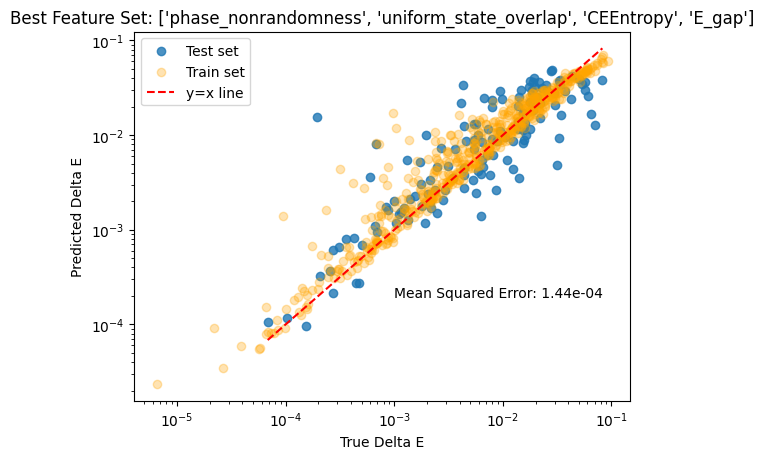

In [ ]:
fig, ax = plt.subplots()
best_features = list(best_features)
traindf = df_mine[best_features + ['Delta_E']].dropna()
traindf = traindf[traindf['Delta_E'] <  0.1]
X_train, X_test, y_train, y_test = train_test_split(traindf[best_features], traindf['Delta_E'], test_size=0.2, random_state=42)
y_pred = best_model.predict(X_test[best_features])
y_pred_train = best_model.predict(X_train[best_features])
print(len(y_train), len(y_test))
mse = mean_squared_error(y_test, y_pred)
ax.scatter(y_test, y_pred, alpha=0.8,label='Test set')
ax.scatter(y_train, y_pred_train, alpha=0.3, color='orange',label='Train set')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('True Delta E')   
ax.set_ylabel('Predicted Delta E')
ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='y=x line')
ax.legend()
ax.text(0.001, min(y_pred)*2, f'Mean Squared Error: {mse:.2e}', fontsize=10)
ax.set_title(f'Best Feature Set: {best_features}')
# ax.scatter(y_test, y_pred_xgb, alpha=0.5, color='green')

/tmp/ipykernel_4062288/3845647188.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(best_features, rotation=45, ha='right')


Text(0, 0.5, 'Feature Importance / Mutual Information with Delta E')

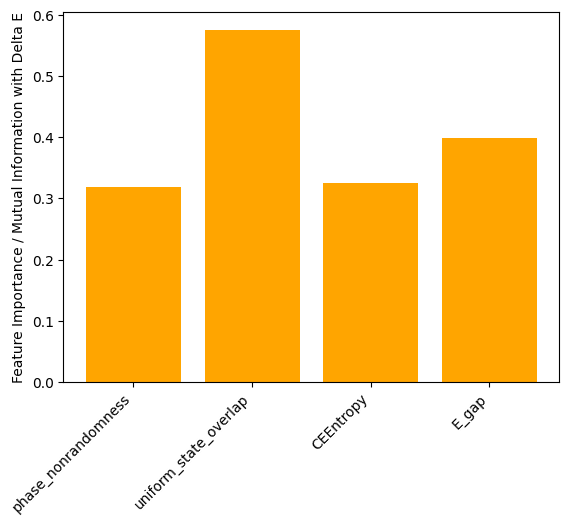

In [ ]:
fig, ax = plt.subplots(1)
mutual_information = mutual_info_regression(traindf[best_features], traindf['Delta_E'])
ax.bar(best_features, mutual_information, color='orange', alpha=1.0)
ax.set_xticklabels(best_features, rotation=45, ha='right')
ax.set_ylabel('Feature Importance / Mutual Information with Delta E')

<Axes: >

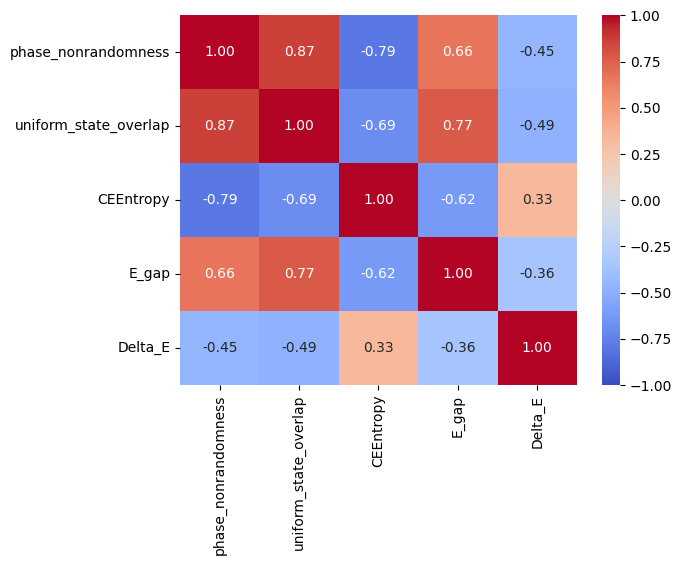

In [ ]:
import seaborn as sns
corr = traindf.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
   

In [ ]:
best_model

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",1000
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsampl

In [ ]:
heisenberg_files = [f'{data_root}/data/tunable_frustration_Heisenberg_rbm/{fp}' for fp in os.listdir(f'{data_root}/data/tunable_frustration_Heisenberg_rbm') if fp.endswith('.h5')]
heisenberg_df = analysis.load_outputs_to_dataframe_mult_thread(heisenberg_files, load_eigenstates=False, num_workers=4)
heisenberg_df.head()
 

,psi,psi_0,Delta_E,E_exact,E_var,infidelity,exact_energies,exact_eigenstates,file,E_gap,...,Ly,alpha,diag_shift,learning_rate,model_name,n_iter,out,run_idx,seed,show_progress
0,"[(3.771817e-12+2.1838506e-10j), (-2.7060993e-0...",[(9.208734523546483e-18+2.0465126465270947e-20...,0.008533,-48.123784,-47.713128,0.016816,"[-48.123784461158664, -40.1237844611586, -39.2...",None,../data/tunable_frustration_Heisenberg_rbm/rbm...,8.000000,...,2,1,0.0001,0.001,J1-J2 Kagome,1000,../data/tunable_frustration_Heisenberg_rbm/rbm...,2003,1234,False
1,"[(1.4488903e-09-9.109211e-10j), (-8.309651e-10...",[(-1.0867435826418425e-17-2.8135622694739774e-...,0.000001,-51.447814,-51.447757,0.000002,"[-51.44781421990092, -45.21933975700781, -43.4...",None,../data/tunable_frustration_Heisenberg_rbm/rbm...,6.228474,...,2,1,0.0001,0.001,J1-J2 Kagome,1000,../data/tunable_frustration_Heisenberg_rbm/rbm...,2016,1234,False
2,"[(-4.260018e-06-1.3063939e-05j), (5.037969e-06...",[(1.1358527388202552e-17+2.419207653517388e-20...,0.017444,-24.845780,-24.412360,0.041530,"[-24.845780354964987, -21.16876684852903, -21....",None,../data/tunable_frustration_Heisenberg_rbm/rbm...,3.677014,...,4,1,0.0001,0.001,J1-J2 Square,1000,../data/tunable_frustration_Heisenberg_rbm/rbm...,3,1234,False
3,"[(-1.6961387e-08-3.601445e-08j), (-1.3803881e-...",[(-1.1429145179406098e-17-2.1737954851624628e-...,0.000063,-51.057216,-51.054013,0.000020,"[-51.05721598833348, -44.83896267925294, -43.0...",None,../data/tunable_frustration_Heisenberg_rbm/rbm...,6.218253,...,2,1,0.0001,0.001,J1-J2 Kagome,1000,../data/tunable_frustration_Heisenberg_rbm/rbm...,2015,1234,False
4,"[(0.00023226066-5.503585e-05j), (3.0193874e-07...",[(-2.9454951095415342e-18-5.529080932549569e-2...,0.020581,-23.536890,-23.052471,0.075173,"[-23.5368895105479, -21.110710119228692, -20.6...",None,../data/tunable_frustration_Heisenberg_rbm/rbm...,2.426179,...,4,1,0.0001,0.001,J1-J2 Square,1000,../data/tunable_frustration_Heisenberg_rbm/rbm...,4,1234,False


In [ ]:
heisenberg_df = analysis.attach_hypotheses_fields_mult_thread(heisenberg_df, hypotheses_CC, num_workers=4)
heisenberg_test_df = heisenberg_df[best_features + ['Delta_E']].dropna()
X_test_heis = heisenberg_test_df[best_features]
y_test_heis = heisenberg_test_df['Delta_E']
y_pred_heis = best_model.predict(X_test_heis)

mse_heis = mean_squared_error(y_test_heis, y_pred_heis)
print(f"Heisenberg Test Set Mean Squared Error: {mse_heis}")


Heisenberg Test Set Mean Squared Error: 0.0010947756886822409


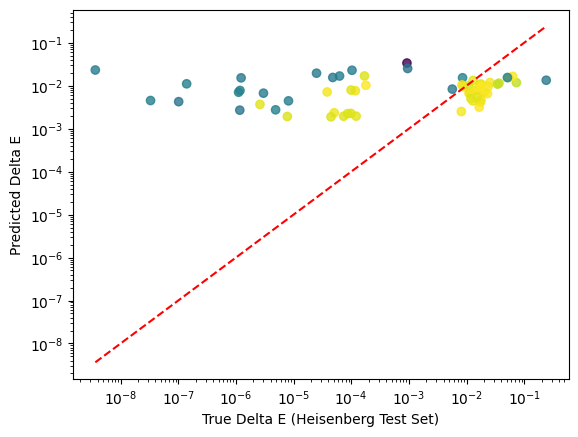

In [ ]:
plt.scatter(y_test_heis, y_pred_heis, alpha=0.8, c=X_test_heis['CEEntropy'], cmap='viridis')
plt.xscale('log')   
plt.yscale('log')
plt.xlabel('True Delta E (Heisenberg Test Set)')   
plt.ylabel('Predicted Delta E')
plt.plot([min(y_test_heis), max(y_test_heis)], [min(y_test_heis), max(y_test_heis)], 'r--', label='y=x line')

In [ ]:
X_test_heis.describe()

,phase_nonrandomness,uniform_state_overlap,CEEntropy,E_gap
count,63.000000,6.300000e+01,63.000000,63.000000
mean,0.037788,7.880678e-34,0.886870,4.637235
std,0.027603,9.813446e-34,0.028760,2.171711
min,0.001542,3.587060e-36,0.805694,0.339067
25%,0.014098,1.192358e-34,0.850836,3.574316
50%,0.032008,3.849057e-34,0.904992,4.824544
75%,0.055748,1.227941e-33,0.907770,6.307826
max,0.114577,4.803018e-33,0.910192,9.716553


In [ ]:
X_test.describe()

,phase_nonrandomness,uniform_state_overlap,CEEntropy,E_gap
count,138.000000,1.380000e+02,138.000000,138.000000
mean,0.498511,2.771983e-01,0.877007,2.074160
std,0.557942,3.481677e-01,0.175545,2.667701
min,0.000143,3.558402e-35,0.187853,-0.065384
25%,0.035028,3.209629e-05,0.906191,0.097419
50%,0.184511,2.656281e-02,0.950239,0.816722
75%,0.995347,6.073118e-01,0.961596,3.389715
max,1.759090,9.838108e-01,0.972462,11.397914


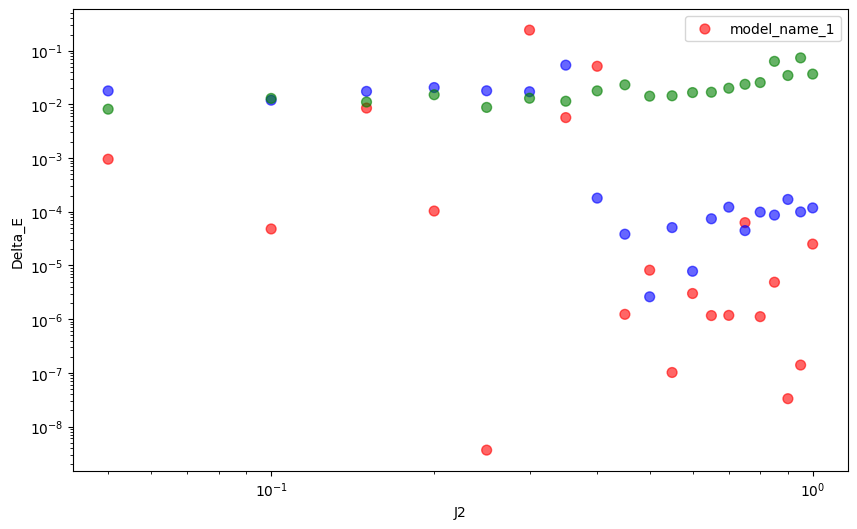

In [ ]:
color_map = {'J1-J2 Kagome': 'red', 'J1-J2 Triangular': 'green', 'J1-J2 Square': 'blue'}  # Adjust these to match your actual model names
colors = heisenberg_df['model_name'].map(color_map)
plt.figure(figsize=(10, 6))
plt.scatter(heisenberg_df['J2'], heisenberg_df['Delta_E'], c=colors, alpha=0.6, s=50)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('J2')
plt.ylabel('Delta_E')
plt.legend(['model_name_1', 'model_name_2', 'model_name_3'], loc='best')
plt.show()

In [ ]:
%matplotlib qt5
import matplotlib as mpl
mpl.use('Qt5Agg')
from cluster_expansion import fwht_coeffs_in_cluster_col_order
hilb_test = nk.hilbert.Spin(1/2, N=12)
mask = heisenberg_df['model_name'] == 'J1-J2 Triangular'
cluster_coeffs_df = heisenberg_df[mask].apply(lambda row: fwht_coeffs_in_cluster_col_order((row['psi_0']), hilb_test), axis=1)
sorted_cluster_coeffs_df = cluster_coeffs_df.apply(lambda x: np.sort(np.abs(x))[::-1])
for idxes in range(len(sorted_cluster_coeffs_df)):
    plt.plot(sorted_cluster_coeffs_df.iloc[idxes])
plt.yscale('log')
for alpha in [1,3,4,5]:
    plt.axvline(x=alpha * 12**2 + 12*(alpha+1), color='r', linestyle='--')


ModuleNotFoundError: No module named 'cluster_expansion'

In [ ]:
heisenberg_df